In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
import seaborn as sns
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

# 初始化Excel Writer，表格均在此excel文件的不同worksheet中
writer = pd.ExcelWriter('output.xlsx', engine='xlsxwriter',datetime_format='yyyy/mm/dd')

In [2]:
# ignore SettingWithCopyWarning
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# 获取数据

In [3]:
def get_stock_dict(tickers, start, end):
    d = {}
    for ticker in tickers:
        df = pd.read_csv('index/' + ticker + '.csv').dropna()
        df.index = pd.to_datetime(df['Unnamed: 0'])
        df = df.drop(['Unnamed: 0'], axis = 1)
        df['PCT_CHG'] = df['PCT_CHG']/100
        df.index.name = 'Date'
        d[ticker] = df.loc[start:end]
        print('Got',len(d[ticker]),"lines of data for", ticker)
#         print(d[ticker].head(5))
    return d

In [4]:
stocks = {'SH000016':'上证50',
          'SH000300':'沪深300',
          'SH000905':'中证500'}

In [5]:
stock_dict = get_stock_dict(list(stocks.keys()), '2005-1-1', '2017-12-29')

Got 3159 lines of data for SH000016
Got 3159 lines of data for SH000300
Got 3159 lines of data for SH000905


# 2.1 成交量较大时指数大概率上涨

p6
1. 数据上除了当日的成交量以外，我们还需取前 N 个交易日的每日成 交量数据，共 N+1 个成交量的值。
2. 将该 N+1 个成交量数据按从小到大进行排序，计算当日成交量在这 N+1 个数值中的排名 n，最小即为 1，最大即为 N+1。
3. 通过运算 2 * (n-N-1) / N 将当日成交量排名标准化为[-1, 1]内的数值。

In [6]:
def rank_index(x):
    temp = x.sort_values(ascending = True).copy()
    ranks = np.arange(1, len(temp)+1)
    rk_df = pd.DataFrame({'volume': temp.values, 'rank':ranks}, 
                         index = temp.index)
    temp2 = rk_df.sort_index().copy()
    n = temp2['rank'][-1]
    return n

Normalized rank: $ \frac{2(n-1)}{N} - 1$

In [7]:
# 连续N天排名
def get_rank(v, N, normalized = True):

    ranks = v.rolling(N+1).apply(rank_index)
    
    if normalized:
        # normalize
        r = np.arange(1, N+2, 1)
        ranks_norm = (2*(ranks-1))/N - 1
        return ranks_norm
    else:
        return ranks

In [8]:
# 未来一周期望收益
def add_fut_exp_rtrn(df_, S):
    df = df_.copy()
    df['nxt_wk_rtrn'] = df['PCT_CHG'].rolling(window=S).sum().shift(-S)
    return df

In [9]:
# 综合排名和未来一周期望收益
def get_rank_rtrn(df):
    table = df[['rank', 'nxt_wk_rtrn']].groupby('rank').mean()
    table = pd.DataFrame({'rank':table.index.tolist(), 'nxt_wk_rtrn':table['nxt_wk_rtrn']})
    return table

In [10]:
# 各宽基的成交量时序排名频次与排名vs未来一周预期收益图表数据汇总
N = 40
S = 5 # weekly
freq = {}
rank_rtrn = {}
corr_future_weekly = {}

for ticker in list(stocks.keys()):
    name = stocks[ticker]
    
    df = stock_dict[ticker]
    df['rank'] = get_rank(df['VOLUME'], N, normalized = True) # get normalized rank
    hist1 = df.groupby('rank').count().iloc[:,0] # count occurance of each rank
    freq[name] = hist1
    
    # get future weekly return
    df = add_fut_exp_rtrn(df, S)
    hist2 = get_rank_rtrn(df)
    corr_future_weekly[name] = hist2.corr().iloc[0,1]
    
    rank_rtrn[name] = hist2['nxt_wk_rtrn']
    stock_dict[ticker] = df # update dfs in dict with the ranks and weekly returns 

In [11]:
print('成交量时序排名与未来一周预期收益相关系数:\n')
print(pd.Series(corr_future_weekly))

成交量时序排名与未来一周预期收益相关系数:

上证50     0.420584
沪深300    0.367359
中证500    0.412998
dtype: float64


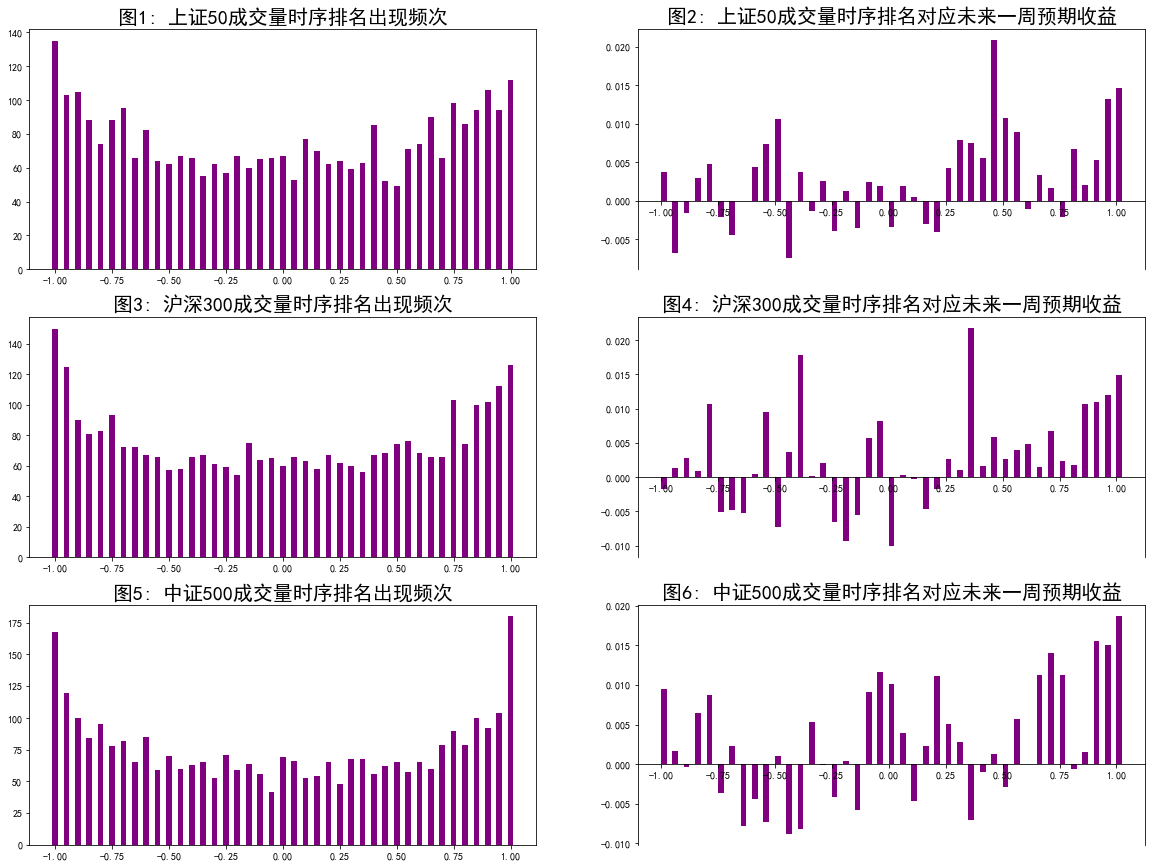

In [12]:
# 画图
fig = plt.figure(figsize = (10*2,5*3))
ax = fig.subplots(nrows=3, ncols=2)

pos = 0
for i in range(len(stocks)):
    
    name = list(stocks.values())[i]
    name1 = '图'+str(pos+1)+': '+name+'成交量时序排名出现频次'
    name2 = '图'+str(pos+2)+': '+name+'成交量时序排名对应未来一周预期收益'
    
    df1 = freq[name]
    df2 = rank_rtrn[name]
    
    ax[i, 0].bar(df1.index.tolist(), df1.values, width = 0.025, align = 'center', color = 'purple')
    ax[i, 0].set_title(name1, fontsize=20)
    
    ax[i, 1].bar(df2.index.tolist(), df2.values, width = 0.025, align = 'edge', color = 'purple')
    ax[i, 1].set_title(name2, fontsize=20)
    ax[i, 1].spines['bottom'].set_position('zero')
    pos+=2
    
plt.savefig('pics/图1-6 成交量较大时指数大概率上涨.png')
plt.show()

# 2.2 根据成交量时序排名构造择时策略

按照成交量时序排名标准化后的符号来定义指数处于放量还是缩量: 

rank > 0 放量，rank < 0 缩量

N 取 40，测试样本为 2010 年至 2017 年。

In [13]:
# 统计放量与缩量的时序排名与未来一周预期收益相关性系数
inc_corr = {}
dec_corr = {}

for ticker in list(stocks.keys()):
    
    name = stocks[ticker]
    df_org = stock_dict[ticker].loc['2010-01-01':].copy()
    df = get_rank_rtrn(df_org) #得到所有排名vs未来一周预期收益
    
    inc = df[df.index > 0].copy() # + 为放量
    inc_corr[name] = inc.corr().iloc[0,1]
    
    dec = df[df.index < 0].copy() # - 为缩量
    dec_corr[name] = dec.corr().iloc[0,1]

inc_corr = pd.Series(inc_corr, name = '放量时序排名')
dec_corr = pd.Series(dec_corr, name = '缩量时序排名')

In [14]:
inc_corr

上证50     0.227990
沪深300    0.622367
中证500    0.668603
Name: 放量时序排名, dtype: float64

In [15]:
dec_corr

上证50    -0.256112
沪深300   -0.344370
中证500   -0.303398
Name: 缩量时序排名, dtype: float64

均与原报告有差异，但仍能看出放量成交量时序排名与未来一周预期收益相关性较缩量更高

In [16]:
# 给bar plot手动添加x轴label
def add_value_labels(ax, spacing=5):

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            fontsize = 13,
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

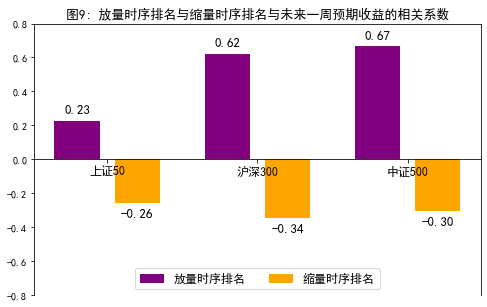

In [17]:
# 画图
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(stocks))
b1 = ax.bar(x, inc_corr, width=0.3, color = 'purple', label = inc_corr.name)
b2 = ax.bar(x+0.4, dec_corr, width=0.3, color = 'orange', label = dec_corr.name)
ax.set_ylim((-0.8, 0.8))
ax.set_title('图9: 放量时序排名与缩量时序排名与未来一周预期收益的相关系数', fontsize = 13)
ax.spines['bottom'].set_position('zero')
# Fix the x-axes.
ax.set_xticks(x + 0.4 / 2)
ax.set_xticklabels(inc_corr.index.tolist(), fontsize = 12)

ax.legend(loc = 'lower center', fontsize = 12, ncol=2)

add_value_labels(ax)
plt.savefig('pics/图9 放量时序排名与缩量时序排名与未来一周预期收益的相关系数')

## 2.2.1 交易策略

1. 计算当日指数的成交量时序排名并标准化为[-1,1]值域内的指标值。
(涉及参数选择 N，时序排名窗口长度)
2. 当成交量时序排名处于最大的一段范围内，或等价的，其标准化后 的值超过一定阈值 S(例如时序排名位于最大的前四分之一，或等价的，标准化后的值超过 0.5)，则开仓买入。(涉及参数选择S，开仓阈值)
3. 当成交量时序排名离开高位，或等价的，其标准化后的值低于一定 阈值 S，则平仓观望。
4. 不进行看空与卖空交易。

In [18]:
# 成交量时序排名策略
class strategy():
    
    def __init__(self, stock_df, n_, s_, start_, end_):
        self.df = stock_df.loc[start_: end_]
        self.n = int(n_)
        self.s = s_

    def rank_index(self,x):
        temp = x.sort_values(ascending = True).copy()
        ranks = np.arange(1, len(temp)+1)
        rk_df = pd.DataFrame({'volume': temp.values, 'rank':ranks}, 
                             index = temp.index)
        temp2 = rk_df.sort_index().copy()
        n = temp2['rank'][-1]
        return n


    def get_rank(self, normalized = True):

        ranks = self.df['VOLUME'].rolling(self.n+1).apply(self.rank_index)

        if normalized:
            # normalize
            
            ranks_norm = (2*(ranks-1))/self.n - 1
            return ranks_norm
        else:
            return ranks
    
    def get_strategy_rtrn(self):
        
        self.df['rank'] = self.get_rank()
        self.df = self.df.dropna()
        

        signs = [0]*len(self.df)
        tax = [0]*len(self.df)
        
        for i in range(len(self.df)-1):
            
            # 当成交量时序排名处于最大的一段范围内，或等价的，其标准化后的值超过一定阈值S，买入
            if self.df['rank'][i] >= self.s:
                signs[i+1] = 1 # next day has return
                
            if (signs[i+1] == 1) & ((signs[i] == 0) | (len(tax) == 0)): # buy
                tax[i+1] = 1 # next day return got tax
                
            elif (signs[i+1] == 0) & (signs[i] == 1) & (len(tax) > 0): # sell
                tax[i+1] = 1 # next day return got tax

        
        self.df['signs'] = signs
        self.df['tax'] = tax
        s_ret = self.df['PCT_CHG'] * self.df['signs']
        self.df['strategy_pct_retrn'] = s_ret
        
        return s_ret
    
    def get_cum_profit(self, cost=False):
        
        ret = self.get_strategy_rtrn()
        daily_incr = 1+self.df['strategy_pct_retrn']

        if cost:
            return ((1 - self.df['tax'] * 0.001)*daily_incr).cumprod() #双边0.1%成本
        else:
            return daily_incr.cumprod()

    def get_wins(self):

        cum_rtrn = 0
        trade_profit = []
        for i in range(len(self.df)):

            if self.df['signs'][i] == 1:
                trade_profit.append(0)
                cum_rtrn += self.df['strategy_pct_retrn'][i]

            elif (self.df['signs'][i-1] == 1) & (self.df['signs'][i] == 0):
                trade_profit.append(cum_rtrn)
                cum_rtrn = 0

            else:
                trade_profit.append(0)

        self.df['trade_profit'] = trade_profit
        return self.df['trade_profit']
        
        
    def get_mdd(self,ts):
        roll_max = ts.cummax() # peaks
        daily_dd = ts/roll_max - 1
        mdd = abs(daily_dd.min())
        return mdd
    
    
    def get_strategy_stats(self, cost=False):

        ret = self.get_strategy_rtrn()
        tp = self.get_wins()

        if cost:
            profit = self.get_cum_profit(True)
            ret = profit.pct_change().dropna()
        else:
            profit = self.get_cum_profit(False)
        
        # annualized return
        ann_ret = ret.mean()*252
        
        # annualized std
        ann_std = ret.std()*np.sqrt(252)

        # maximum drawdown
        mdd = self.get_mdd(profit)
        
        # sharpe ratio
        sharpe = ann_ret / ann_std
        
        # trade count
        t_count = sum(tp != 0)
        
        # pct win
        numwin = sum(tp > 0)
        numloss = t_count - numwin
        
        pct_win = numwin/t_count
        
        # ave p&l ratio
        pl_ratio = abs(tp[tp > 0].mean()/tp[tp < 0].mean())
        
        table = pd.Series([ann_ret, sharpe, mdd, t_count, pct_win, pl_ratio], 
                          index = ['年化收益', '夏普比率', '最大回撤', '交易次数', '胜率', '平均盈亏比'])
        
        return table
    
    def get_annually_stats(self,cost=False):
        
        ret = self.get_strategy_rtrn()
        profit = self.get_cum_profit(cost)
        
        df = self.df.copy()
        df['profit'] = profit
        
        df['year'] = df.index.year
        
        ann_rtrn = df.groupby('year').mean()['strategy_pct_retrn']*252
        ann_vol = df.groupby('year').std()['strategy_pct_retrn']*np.sqrt(252)
        sharpe = ann_rtrn/ann_vol
        
        mdd = df.groupby('year').apply(self.get_mdd)['profit']
        
        end = pd.concat([ann_rtrn, ann_vol, sharpe, mdd], axis = 1)
        end.columns = ["年回报率", "年波动率", "夏普比率", "最大回撤"]
        
        return end
    
    def get_df(self):
        
        self.df['no_cost'] = self.get_cum_profit(False)
        self.df['with_cost'] = self.get_cum_profit(True)
        
        end = pd.DataFrame({'策略净值（交易无成本）': self.df['no_cost'],
                      '策略净值（双边千一成本）': self.df['with_cost'],
                      '净值': self.df['PRE_CLOSE']/self.df['PRE_CLOSE'][0]})

        return end

## 2.2.2 策略参数选择（样本内回测）

In [19]:
# 准备需测试的N和S值
windowsn = np.arange(10,65,5) # [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
thresholds = np.arange(0.2, 0.9, 0.1) # [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# 方便表格命名
row_name = []
for n in windowsn: row_name.append("N="+str(n))

col_name = [] 
for s in thresholds: col_name.append("S="+str(round(s, 1)))

In [22]:
# 统计各宽基在不同（N，S）组合下的策略年化收益与最大回撤
table_dict = {}
for i in range(len(stocks)):
    
    name = list(stocks.values())[i]
    print("Working on", name)
    df = stock_dict[list(stocks.keys())[i]]
    
    ann_rtrn = []
    mdd = []
    
    for n in windowsn:
        a = []
        m = []
        for s in thresholds:
#             print("Getting the strategy for N="+str(n)+", S="+str(round(s, 1)))
            st = strategy(df, n, s, '2005-01-01', '2014-01-01')
            stats = st.get_strategy_stats()
            a.append(stats[0])
            m.append(stats[2])
        ann_rtrn.append(a)
        mdd.append(m)
    
    table_dict[name] = [pd.DataFrame(ann_rtrn, index = row_name, columns = col_name),
                        pd.DataFrame(mdd, index = row_name, columns = col_name)]

Working on 上证50
Working on 沪深300
Working on 中证500


### 表1: 上证50成交量时序排名策略样本内年化收益

In [23]:
pd.options.display.float_format = '{:.1%}'.format
table_dict['上证50'][0].to_excel(writer, '表1 上证50成交量时序排名策略样本内年化收益') #存入excel
table_dict['上证50'][0]

,S=0.2,S=0.3,S=0.4,S=0.5,S=0.6,S=0.7,S=0.8
N=10,8.3%,8.3%,7.9%,7.9%,7.9%,12.1%,8.6%
N=15,8.2%,8.2%,10.1%,10.3%,10.3%,10.5%,12.5%
N=20,13.7%,13.7%,8.3%,12.5%,12.5%,15.8%,12.4%
N=25,12.1%,12.4%,11.5%,12.6%,13.3%,14.2%,14.6%
N=30,15.8%,13.3%,12.6%,14.6%,11.8%,16.1%,13.6%
N=35,15.3%,16.4%,14.7%,15.4%,15.1%,13.7%,14.1%
N=40,17.2%,16.3%,16.0%,14.3%,14.4%,10.5%,11.4%
N=45,13.3%,14.8%,16.3%,12.4%,12.5%,10.1%,13.8%
N=50,13.1%,12.2%,11.5%,12.4%,12.6%,11.5%,13.6%
N=55,14.2%,11.6%,12.3%,13.3%,15.2%,11.8%,11.7%


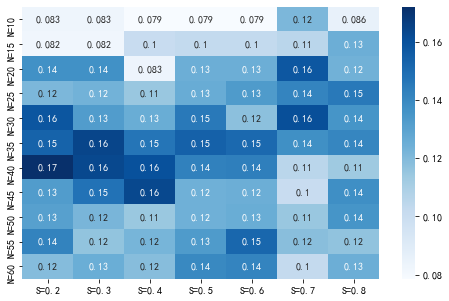

In [24]:
#热点图，方便分析数值分布
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(table_dict['上证50'][0], cmap='Blues', annot=True)

根据样本内回测，策略年化收益在参数N为35左右，S为0.2-0.4的年化收益均较高

### 表2: 上证50成交量时序排名策略样本内最大回撤(绝对值)

In [25]:
table_dict['上证50'][1].to_excel(writer, '表2 上证50成交量时序排名策略样本内最大回撤(绝对值)') #存入excel
table_dict['上证50'][1]

,S=0.2,S=0.3,S=0.4,S=0.5,S=0.6,S=0.7,S=0.8
N=10,36.7%,36.7%,34.2%,34.2%,34.2%,24.1%,21.0%
N=15,36.1%,36.1%,29.8%,20.3%,20.3%,27.6%,22.6%
N=20,37.7%,37.7%,32.1%,24.3%,24.3%,17.2%,20.8%
N=25,34.7%,33.3%,36.5%,31.7%,21.8%,18.5%,13.9%
N=30,36.3%,34.4%,26.3%,27.9%,27.8%,12.8%,9.2%
N=35,33.3%,30.3%,25.0%,20.4%,24.6%,15.5%,9.2%
N=40,36.2%,30.2%,25.0%,24.4%,19.8%,11.2%,9.2%
N=45,49.4%,34.8%,29.1%,28.8%,26.2%,19.5%,9.3%
N=50,48.8%,48.2%,28.0%,28.0%,25.8%,22.1%,8.1%
N=55,46.7%,43.5%,31.0%,27.2%,27.8%,25.8%,10.3%


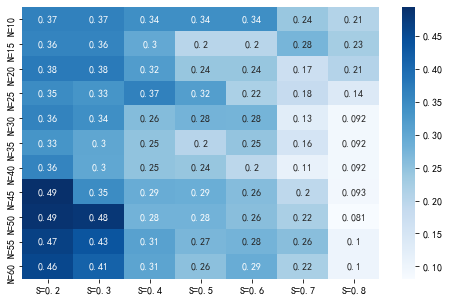

In [26]:
#热点图，方便分析数值分布
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(table_dict['上证50'][1], cmap='Blues', annot=True)

策略最大回撤在N=40左右较好，最大回撤随S增大单调减小。

综合考虑，中证50的策略参数选择 **N=30，S=0.7**

In [27]:
#所选参数下的策略统计数据
pd.reset_option('display')
zz50 = strategy(stock_dict['SH000016'], 30, 0.7, '2005-01-01', '2014-01-01')
zz50.get_strategy_stats()

年化收益       0.160927
夏普比率       1.214943
最大回撤       0.127596
交易次数     206.000000
胜率         0.597087
平均盈亏比      1.626718
dtype: float64

### 表3: 沪深 300 成交量时序排名策略样本内年化收益

In [28]:
pd.options.display.float_format = '{:.1%}'.format
table_dict['沪深300'][0].to_excel(writer, '表3 沪深300成交量时序排名策略样本内年化收益')
table_dict['沪深300'][0]

,S=0.2,S=0.3,S=0.4,S=0.5,S=0.6,S=0.7,S=0.8
N=10,14.5%,14.5%,10.9%,10.9%,10.9%,8.1%,10.0%
N=15,10.8%,10.8%,12.3%,15.1%,15.1%,12.6%,8.8%
N=20,17.9%,17.9%,14.2%,14.4%,14.4%,13.3%,9.5%
N=25,19.4%,18.5%,17.6%,15.8%,14.1%,12.9%,13.1%
N=30,21.6%,20.8%,18.7%,16.4%,14.0%,14.7%,13.5%
N=35,22.8%,21.2%,18.3%,16.6%,16.0%,15.3%,15.7%
N=40,21.8%,22.4%,18.7%,17.5%,15.9%,13.9%,13.3%
N=45,18.1%,22.7%,21.3%,17.6%,17.6%,15.0%,12.6%
N=50,16.5%,20.3%,20.8%,16.3%,15.8%,14.7%,11.0%
N=55,16.8%,18.8%,21.4%,18.4%,15.6%,16.0%,10.8%


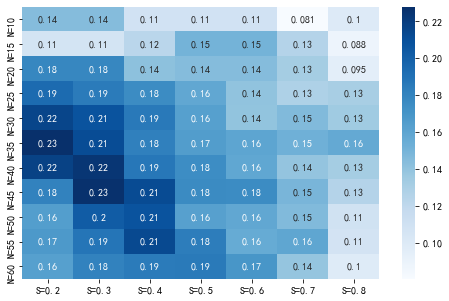

In [29]:
#热点图，方便分析数值分布
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(table_dict['沪深300'][0], cmap='Blues', annot=True)

### 表4: 沪深 300 成交量时序排名策略样本内最大回撤(绝对值)

In [30]:
table_dict['沪深300'][1].to_excel(writer, '表4 沪深300成交量时序排名策略样本内最大回撤(绝对值)')
table_dict['沪深300'][1]

,S=0.2,S=0.3,S=0.4,S=0.5,S=0.6,S=0.7,S=0.8
N=10,29.3%,29.3%,31.0%,31.0%,31.0%,26.8%,12.9%
N=15,31.7%,31.7%,30.6%,19.9%,19.9%,19.0%,20.9%
N=20,24.2%,24.2%,23.1%,25.3%,25.3%,18.5%,17.5%
N=25,18.3%,21.6%,19.8%,22.2%,27.0%,14.6%,12.4%
N=30,24.4%,22.6%,16.1%,18.0%,20.1%,16.0%,12.9%
N=35,23.1%,23.1%,20.6%,18.9%,15.8%,13.2%,11.7%
N=40,21.2%,22.6%,17.5%,15.8%,18.9%,10.6%,11.3%
N=45,36.6%,21.3%,23.1%,16.2%,16.0%,15.8%,11.7%
N=50,39.1%,27.8%,18.4%,16.7%,18.9%,16.8%,11.9%
N=55,36.5%,29.1%,20.8%,19.8%,18.9%,17.4%,13.0%


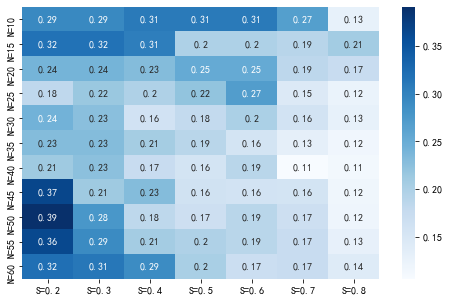

In [31]:
#热点图，方便分析数值分布
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(table_dict['沪深300'][1], cmap='Blues', annot=True)

综合较大年化收益，较小最大回撤来看，沪深300选择**N=35，S=0.8**

### 表 5:中证 500 成交量时序排名策略样本内年化收益

In [32]:
table_dict['中证500'][0].to_excel(writer, '表5 中证500成交量时序排名策略样本内年化收益')
table_dict['中证500'][0]

,S=0.2,S=0.3,S=0.4,S=0.5,S=0.6,S=0.7,S=0.8
N=10,19.7%,19.7%,20.4%,20.4%,20.4%,20.9%,14.8%
N=15,24.9%,24.9%,21.0%,23.4%,23.4%,20.9%,18.3%
N=20,27.1%,27.1%,21.0%,22.2%,22.2%,20.5%,16.9%
N=25,26.6%,26.2%,25.2%,25.0%,23.2%,20.5%,18.0%
N=30,28.5%,28.6%,26.7%,25.8%,23.4%,21.6%,17.6%
N=35,26.0%,26.9%,24.4%,26.6%,24.9%,19.9%,15.9%
N=40,25.5%,27.2%,25.7%,22.6%,21.1%,16.3%,11.2%
N=45,29.3%,27.3%,22.5%,20.1%,19.4%,17.5%,13.2%
N=50,26.4%,24.7%,19.8%,18.9%,19.5%,17.9%,11.8%
N=55,24.7%,22.3%,21.7%,19.6%,17.0%,16.1%,12.6%


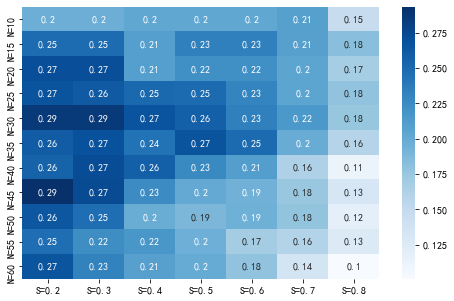

In [33]:
#热点图，方便分析数值分布
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(table_dict['中证500'][0], cmap='Blues', annot=True)

### 表6: 中证 500 成交量时序排名策略样本内最大回撤(绝对值)

In [34]:
table_dict['中证500'][1].to_excel(writer, '表6 成交量时序排名策略样本内最大回撤(绝对值)')
table_dict['中证500'][1]

,S=0.2,S=0.3,S=0.4,S=0.5,S=0.6,S=0.7,S=0.8
N=10,24.3%,24.3%,23.1%,23.1%,23.1%,17.8%,18.2%
N=15,21.6%,21.6%,21.9%,20.0%,20.0%,20.0%,18.9%
N=20,20.0%,20.0%,23.4%,13.8%,13.8%,11.7%,8.3%
N=25,20.6%,18.4%,15.7%,17.8%,13.8%,12.4%,10.3%
N=30,18.4%,18.4%,15.5%,17.1%,12.8%,9.5%,9.9%
N=35,18.7%,20.3%,19.5%,13.3%,13.3%,11.3%,8.8%
N=40,18.4%,19.8%,19.5%,19.5%,14.4%,16.7%,16.2%
N=45,18.4%,18.4%,18.4%,20.1%,20.8%,15.8%,16.9%
N=50,25.4%,25.5%,26.8%,22.5%,19.5%,14.3%,16.9%
N=55,35.2%,34.3%,20.1%,19.1%,19.5%,18.3%,14.2%


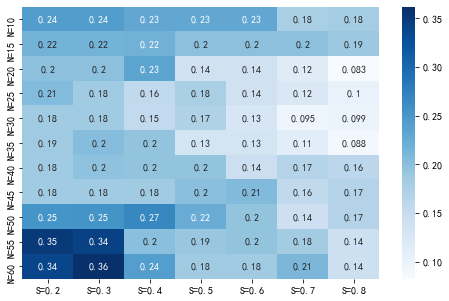

In [35]:
#热点图，方便分析数值分布
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(table_dict['中证500'][1], cmap='Blues', annot=True)

综合来看，选取**N=30, S=0.5**

## 2.2.3 样本内外净值对比

In [36]:
pd.options.display.float_format = '{:.3f}'.format

In [37]:
#整理目前所选参数
params = pd.DataFrame(data = [[30,0.7],[35, 0.8], [30, 0.5]], 
                      index = stocks.values(), 
                      columns = ['N', 'S'])
params

,N,S
上证50,30,0.700
沪深300,35,0.800
中证500,30,0.500


In [38]:
#统计各宽基样本内和样本外的策略净值情况，准备图表所需数据
insample_dict = {}
outsample_dict = {}
for i in range(len(stocks)):
    
    name = list(stocks.values())[i]
    df = stock_dict[list(stocks.keys())[i]]
    n,s = params.loc[name].values
    
    st_in = strategy(df, int(n), s, '2005-01-01', '2014-01-01')
    st_out = strategy(df, int(n), s, '2014-01-01', '2018-01-01')
    
    insample_dict[name] = st_in.get_df()
#     print('Got '+name+' in sample')
    outsample_dict[name] = st_out.get_df()
#     print('Got '+name+' out sample')

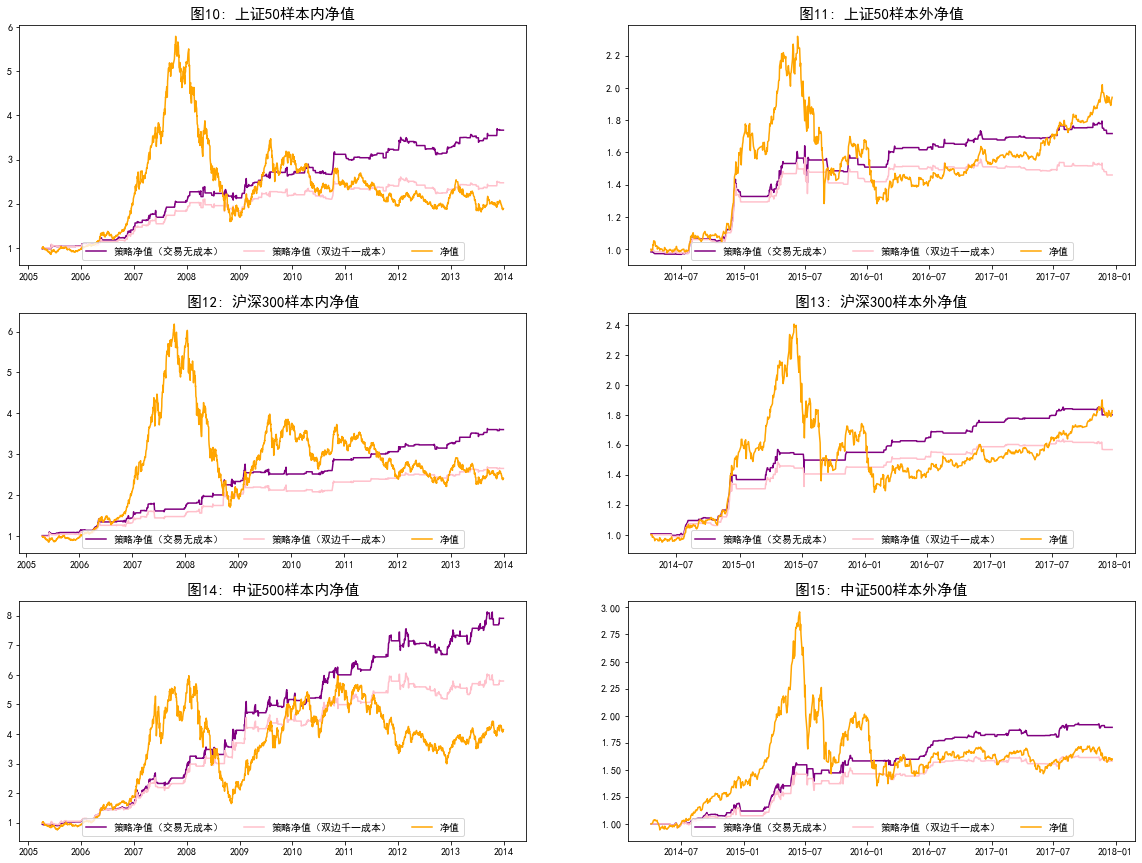

In [39]:
#画图
fig = plt.figure(figsize = (10*2,5*3))
ax = fig.subplots(nrows=3, ncols=2)

pos = 0
colors = ['purple', 'pink', 'orange']
for i in range(len(stocks)):
    
    name = list(stocks.values())[i]
    name1 = '图'+str(pos+10)+': '+name+'样本内净值'
    name2 = '图'+str(pos+11)+': '+name+'样本外净值'
    
    df1 = insample_dict[name]
    df2 = outsample_dict[name]
    
    ax[i, 0].plot(df1)
    for j in range(len(df1.columns)): 
        ax[i, 0].get_lines()[j].set_color(colors[j])
        ax[i, 0].get_lines()[j].set_label(df1.columns.tolist()[j])
    ax[i, 0].set_title(name1, fontsize=15)
    ax[i, 0].legend(loc = 'lower center', ncol=len(df1.columns))
    
    ax[i, 1].plot(df2)
    for j in range(len(df2.columns)): 
        ax[i, 1].get_lines()[j].set_color(colors[j])
        ax[i, 1].get_lines()[j].set_label(df1.columns.tolist()[j])
    ax[i, 1].set_title(name2, fontsize=15)
    ax[i, 1].legend(loc = 'lower center', ncol=len(df2.columns))
    pos+=2
    
plt.savefig('pics/图10-15 各宽基样本内外净值.png')
plt.show()

### 表7: 成交量时序排名择时策略样本内外统计数据

In [40]:
#统计各宽基样本内和样本外的策略统计数据
insample_stats = {}
outsample_stats = {}
for i in range(len(stocks)):
    
    name = list(stocks.values())[i]
    df = stock_dict[list(stocks.keys())[i]]
    n,s = params.loc[name].values
    
    st_in = strategy(df, int(n), s, '2005-01-01', '2014-01-01')
    st_out = strategy(df, int(n), s, '2014-01-01', '2018-01-01')
    
    insample_stats[name] = st_in.get_strategy_stats()
#     print('Got '+name+' in sample stats')
    outsample_stats[name] = st_out.get_strategy_stats()
#     print('Got '+name+' out sample stats')

In [41]:
#整理数据至同一表格
df1 = pd.DataFrame(insample_stats)
df2 = pd.DataFrame(outsample_stats)
df_all = pd.concat([df1, df2], axis=1)

columns=[('样本内 (2005.1.1-2014.1.1)', '上证50'), ('样本内 (2005.1.1-2014.1.1)', '沪深300'), ('样本内 (2005.1.1-2014.1.1)', '中证500'), ('样本外 (2014.1.1-2018.1.1)', '上证50'), ('样本外 (2014.1.1-2018.1.1)', '沪深300'), ('样本外 (2014.1.1-2018.1.1)', '中证500')]
df_all.columns = pd.MultiIndex.from_tuples(columns)

In [42]:
#每行单独进行format
def format_row_wise(styler, formatter):
    for row, row_formatter in formatter.items():
        row_num = styler.index.get_loc(row)

        for col_num in range(len(styler.columns)):
            styler._display_funcs[(row_num, col_num)] = row_formatter
    return styler
formatters = {
    '年化收益': lambda x: f'{x:.1%}',
    '夏普比率': lambda x: f'{x:.2f}',
    '最大回撤': lambda x: f'{x:.1%}',
    '交易次数': lambda x: f'{x:.0f}',
    '胜率': lambda x: f'{x:.1%}',
    '平均盈亏比': lambda x: f'{x:.2f}'
}

In [43]:
#输出为指定格式
styler = format_row_wise(df_all.style, formatters)
styler

In [44]:
styler.to_excel(writer, '表7 成交量时序排名择时策略样本内外统计数据') #存至excel

### 表 8:成交量时序排名择时策略分年度统计数据

In [45]:
#获取年度数据
annual_stats = {}
for i in range(len(stocks)):
    
    name = list(stocks.values())[i]
    df = stock_dict[list(stocks.keys())[i]]
    n,s = params.loc[name].values
    
    st = strategy(df, int(n), s, '2005-01-01', '2018-01-01')
    
    annual_stats[name] = st.get_annually_stats()
#     print('Got '+name+' annual stats')

In [46]:
#整理年度数据
df_all = pd.concat([list(annual_stats.values())[i]for i in range(len(annual_stats))], axis=1)

columns = []
for i in range(len(annual_stats)):
    name = list(annual_stats.keys())[i]
    df = annual_stats[name]
    for col in df.columns:
        
        columns.append((name, col))
        
df_all.columns = pd.MultiIndex.from_tuples(columns)
df_all.to_excel(writer, '表8 成交量时序排名择时策略分年度统计数据')

In [47]:
pd.options.display.float_format = '{:.3f}'.format

In [48]:
df_all

上证50                   沪深300                   中证500                  
      年回报率  年波动率  夏普比率  最大回撤  年回报率  年波动率  夏普比率  最大回撤  年回报率  年波动率  夏普比率  最大回撤
year                                                                        
2005 0.084 0.117 0.722 0.047 0.099 0.113 0.876 0.046 0.133 0.152 0.876 0.098
2006 0.367 0.130 2.817 0.041 0.308 0.122 2.525 0.053 0.503 0.159 3.166 0.062
2007 0.366 0.145 2.526 0.083 0.171 0.129 1.321 0.117 0.569 0.238 2.395 0.171
2008 0.064 0.234 0.275 0.128 0.357 0.222 1.606 0.074 0.438 0.270 1.624 0.092
2009 0.243 0.147 1.653 0.078 0.087 0.133 0.653 0.095 0.251 0.191 1.311 0.097
2010 0.167 0.105 1.580 0.080 0.137 0.068 2.024 0.026 0.166 0.143 1.161 0.080
2011 0.034 0.069 0.496 0.042 0.069 0.036 1.899 0.011 0.186 0.095 1.957 0.053
2012 0.022 0.087 0.256 0.112 0.070 0.065 1.069 0.042 0.018 0.124 0.142 0.116
2013 0.123 0.082 1.496 0.050 0.104 0.054 1.921 0.024 0.103 0.116 0.891 0.063
2014 0.299 0.149 2.003 0.074 0.317 0.119 2.665 0.045 0.192 0.123 1.561 0.060
2015 0.151 0.194 0.779 0.139 0.136 0.122 1.115 0.102 0.381 0.214 1.781 0.107
2016 0.115 0.075 1.536 0.030 0.127 0.047 2.679 0.007 0.151 0.072 2.111 0.030
2017 0.022 0.047 0.472 0.043 0.030 0.041 0.736 0.030 0.040 0.066 0.595 0.038

# 3.1 成交量时序排名结合价格走势

如果指数前 10 日涨幅小于-5%，则认为目前处于熊市;

如果指数前 10 日涨幅大于 5%，则认为目前处于牛市;

如果指数前 10 日涨幅处于-5%到 5%之间，则认为目前是震荡市。

原文用到上证综指，这里复现使用沪深300。

In [49]:
#获取前10日涨幅
df = stock_dict[list(stock_dict.keys())[1]]
df['ten_day_rtrn'] = df['PCT_CHG'].rolling(10).sum()

In [50]:
#按5%分出牛市、熊市和震荡市，并统计排名出现频次和排名vs预期涨幅
df['bull_mkt'] = df[df['ten_day_rtrn'] > 0.05]['PCT_CHG']
df['bear_mkt'] = df[df['ten_day_rtrn'] < -0.05]['PCT_CHG']
df['vol_mkt'] = df[(df['ten_day_rtrn'] <= 0.05) & (df['ten_day_rtrn'] >= -0.05)]['PCT_CHG']
d = df[['rank', 'ten_day_rtrn', 'bull_mkt', 'bear_mkt', 'vol_mkt']].copy()

fig_hist = {}
fig_rtrn = {}

hist = d.groupby('rank').count().copy()
fig_hist['沪深300熊市中'] = hist['bear_mkt']
fig_hist['沪深300震荡市中'] = hist['vol_mkt']
fig_hist['沪深300牛市中'] = hist['bull_mkt']

rtrn = d.groupby('rank').mean().copy()
fig_rtrn['沪深300熊市中'] = rtrn['bear_mkt']
fig_rtrn['沪深300震荡市中'] = rtrn['vol_mkt']
fig_rtrn['沪深300牛市中'] = rtrn['bull_mkt']

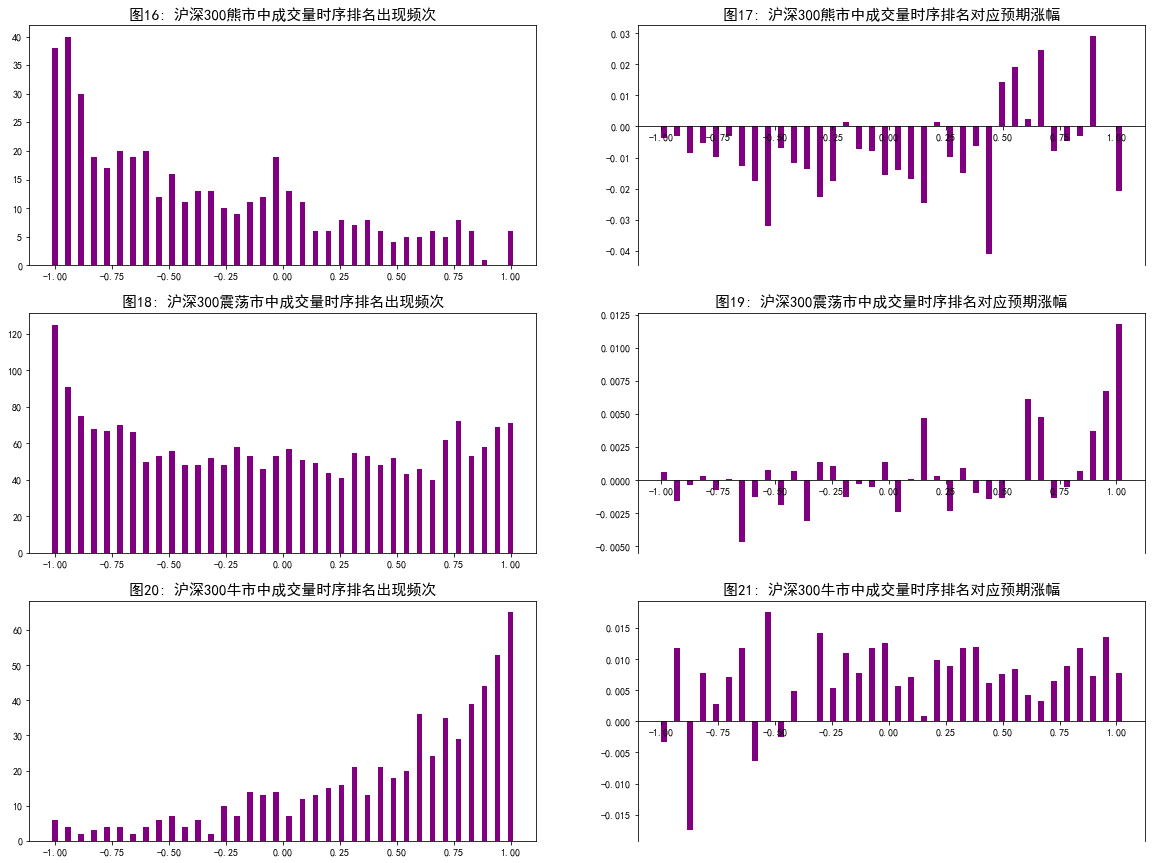

In [51]:
#画图
fig = plt.figure(figsize = (10*2,5*3))
ax = fig.subplots(nrows=3, ncols=2)

pos = 15
for i in range(len(stocks)):
    
    name = list(fig_hist.keys())[i]
    name1 = '图'+str(pos+1)+': '+name+'成交量时序排名出现频次'
    name2 = '图'+str(pos+2)+': '+name+'成交量时序排名对应预期涨幅'
    
    df1 = fig_hist[name]
    df2 = fig_rtrn[name]
    
    ax[i, 0].bar(df1.index.tolist(), df1.values, width = 0.025, align = 'center', color = 'purple')
    ax[i, 0].set_title(name1, fontsize=15)
    
    ax[i, 1].bar(df2.index.tolist(), df2.values, width = 0.025, align = 'edge', color = 'purple')
    ax[i, 1].set_title(name2, fontsize=15)
    ax[i, 1].spines['bottom'].set_position('zero')
    pos+=2
    
plt.savefig('pics/图16-21 成交量时序排名结合价格走势.png')
plt.show()

In [52]:
# 基于指数行情的成交量时序排名择时策略
class mkt_strategy(strategy):
    
    def __init__(self, stock_df, n_, s_, start_, end_, c_, sf_, sc_, sr_):
        super().__init__(stock_df, n_, s_, start_, end_)
        self.c = c_ # mkt seperation threshold
        self.sf = sf_ # bear
        self.sc = sc_ # vol
        self.sr = sr_ # bull

    def get_strategy_rtrn(self, cost=False):
        
        self.df['rank'] = self.get_rank()
        self.df = self.df.dropna()
        self.df['ten_day_rtrn'] = self.df['PCT_CHG'].rolling(10).sum()

        signs = [0]*len(self.df)
        tax = [0]*len(self.df)
        
        for i in range(len(self.df)-1):
            
            # bull mkt
            if self.df['ten_day_rtrn'][i] > self.c:
               
                if self.df['rank'][i] >= self.sr: # sr as bull mkt sign
                    signs[i+1] = 1 # next day has return

                if (signs[i+1] == 1) & ((signs[i] == 0) | (len(tax) == 0)): # buy
                    tax[i+1] = 1 # next day return got tax

                elif (signs[i+1] == 0) & (signs[i] == 1) & (len(tax) > 0): # sell
                    tax[i+1] = 1 # next day return got tax
                    
            # bear mkt
            elif self.df['ten_day_rtrn'][i] < -self.c:
               
                if self.df['rank'][i] >= self.sf: # sf as bear mkt sign
                    signs[i+1] = 1 # next day has return

                if (signs[i+1] == 1) & ((signs[i] == 0) | (len(tax) == 0)): # buy
                    tax[i+1] = 1 # next day return got tax

                elif (signs[i+1] == 0) & (signs[i] == 1) & (len(tax) > 0): # sell
                    tax[i+1] = 1 # next day return got tax
            
            # vol mkt
            else:
               
                if self.df['rank'][i] >= self.sc: # sc as vol mkt sign
                    signs[i+1] = 1 # next day has return

                if (signs[i+1] == 1) & ((signs[i] == 0) | (len(tax) == 0)): # buy
                    tax[i+1] = 1 # next day return got tax

                elif (signs[i+1] == 0) & (signs[i] == 1) & (len(tax) > 0): # sell
                    tax[i+1] = 1 # next day return got tax
                
        
        self.df['signs'] = signs
        self.df['tax'] = tax
        s_ret = self.df['PCT_CHG'] * self.df['signs']
        self.df['strategy_pct_retrn'] = s_ret

        return s_ret

In [53]:
#重置原始数据
stock_dict = get_stock_dict(list(stocks.keys()), '2005-1-1', '2017-12-29')

Got 3159 lines of data for SH000016
Got 3159 lines of data for SH000300
Got 3159 lines of data for SH000905


In [54]:
#测试上证50不同（C，Sr）下的策略年化收益以确定适合上证50的参数
cs = np.arange(0.03, 0.09, 0.01)
srs = np.arange(0, 0.6, 0.1)

r = []
for c in cs:
    x = []
    for sr in srs:
        st = mkt_strategy(stock_dict[list(stocks.keys())[0]], 30, 0.5, '2005-03-14', '2017-12-29', c, 0.8, 0.5, sr)
        ret = st.get_strategy_rtrn()
        ann_ret = ret.mean()*252
#         print('Got', (c, sr))
        x.append(ann_ret)
        
    r.append(x)

r = np.array(r)

In [55]:
#获得label方便制图
cs_label = ['C='+str(round(c, 2)) for c in cs]
srs_label = ['Sr='+str(round(sr, 1)) for sr in srs]

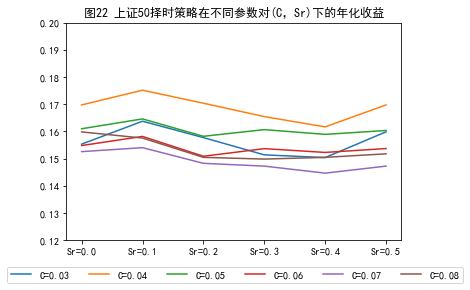

In [56]:
#画图
plt.plot(r)
axes = plt.gca()
axes.set_ylim([0.12, 0.2])
axes.set_xticklabels([0]+srs_label)
for k in range(len(cs_label)): 
    axes.get_lines()[k].set_label(cs_label[k])
axes.legend(bbox_to_anchor=(1.2, -0.1), ncol=len(cs_label))
axes.set_title('图22 上证50择时策略在不同参数对(C，Sr)下的年化收益')
plt.savefig('pics/图22 上证50择时策略在不同参数对(C，Sr)下的年化收益.png')
plt.show()

从上图可见，Sr取值为0.1时，上证50则是策略收益普遍为最高，行情划分参数在0.04为最好。沪深300与上证500取值和报告相同

In [57]:
#添加新的参数
params['C'] = [0.04, 0.05, 0.05]
params['Sf'] = [0.8, 0.8, 0.8]
params['Sc'] = [0.5, 0.5, 0.5]
params['Sr'] = [0.1,0.2, 0.4]
params

,N,S,C,Sf,Sc,Sr
上证50,30,0.700,0.040,0.800,0.500,0.100
沪深300,35,0.800,0.050,0.800,0.500,0.200
中证500,30,0.500,0.050,0.800,0.500,0.400


In [58]:
#各宽基的行情分段成交量时序排名策略与原策略净值比较数据获取
compare_dict = {}
for ticker in list(stocks.keys()):
    name = stocks[ticker]
    df = stock_dict[ticker]
    n,s,c,sf,sc,sr = params.loc[name].values
    
    st1 = strategy(df, int(n), s, '2005-03-14', '2017-12-29')
    st2 = mkt_strategy(df, int(n), s, '2005-03-14', '2017-12-29',c,sf,sc,sr)
    
    c1 = st1.get_cum_profit()
    c2 = st2.get_cum_profit()
    net = st1.df['PRE_CLOSE']/st1.df['PRE_CLOSE'][0]
    
    end = pd.DataFrame({name: net,
                      '成交量时序排名策略': c1,
                      '行情分段成交量时序排名策略': c2})
    compare_dict[name] = end

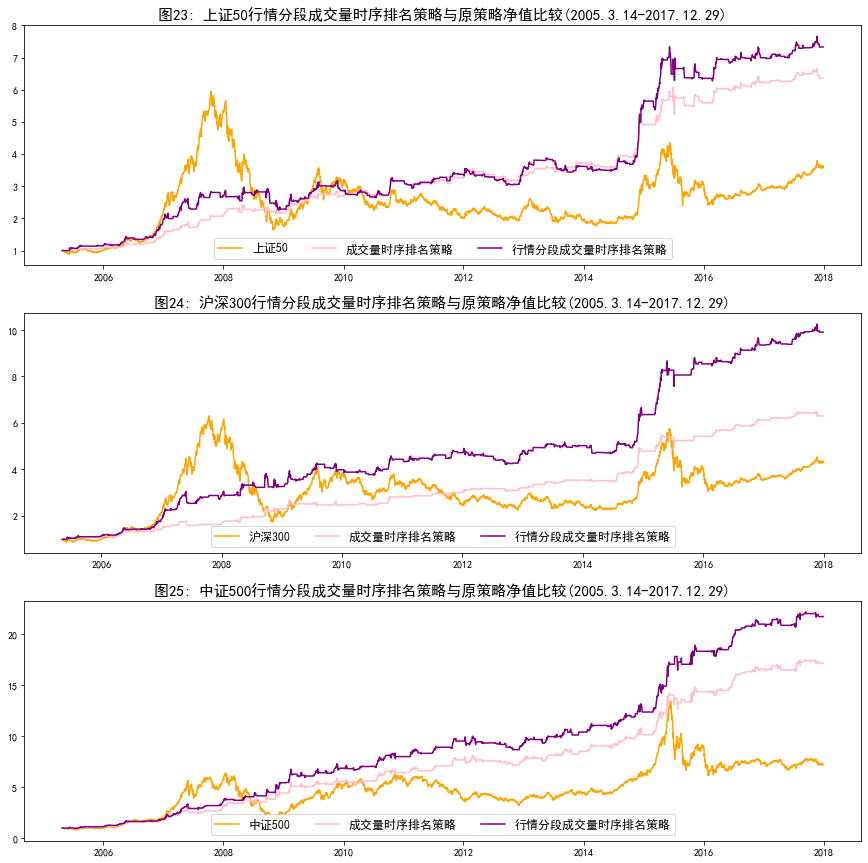

In [59]:
#画图
fig = plt.figure(figsize = (15,5*3))
ax = fig.subplots(nrows=3, ncols=1)

pos = 23
colors = ['orange', 'pink', 'purple']
for i in range(len(stocks)):
    
    name = list(stocks.values())[i]
    name1 = '图'+str(pos+i)+': '+name+'行情分段成交量时序排名策略与原策略净值比较(2005.3.14-2017.12.29)'
    
    df1 = compare_dict[name]
    
    ax[i].plot(df1)
    for j in range(len(df1.columns)): 
        ax[i].get_lines()[j].set_color(colors[j])
        ax[i].get_lines()[j].set_label(df1.columns.tolist()[j])
    ax[i].set_title(name1, fontsize=15)
    ax[i].legend(loc = 'lower center', ncol=len(df1.columns), fontsize=12)

    
plt.savefig('pics/图23-25 行情分段成交量时序排名策略与原策略净值比较.png')
plt.show()

### 表9: 各宽基指数行情分段策略与原策略统计数据比较(2005.3.14-2017.12.29)

In [60]:
#获取表9数据
stats_dict = {}

for ticker in list(stocks.keys()):
    name = stocks[ticker]
    df = stock_dict[ticker]
    n,s,c,sf,sc,sr = params.loc[name].values
    
    st1 = strategy(df, int(n), s, '2005-03-14', '2017-12-29')
    st2 = mkt_strategy(df, int(n), s, '2005-03-14', '2017-12-29',c,sf,sc,sr)
    
    s1 = st1.get_strategy_stats(True)
#     print('Got 原策略 stats for',name)
    s2 = st2.get_strategy_stats(True)
#     print('Got 行情分段 stats for',name)
          
    end = pd.DataFrame({'原策略': s1, '行情分段': s2})
    stats_dict[name] = end

In [61]:
#整理数据至同一表格
df_compare = pd.concat([list(stats_dict.values())[i]for i in range(len(stats_dict))], axis=1)

columns = []
for i in range(len(stats_dict)):
    name = list(stats_dict.keys())[i]
    df = stats_dict[name]
    for col in df.columns:
        
        columns.append((name, col))
df_compare.columns = pd.MultiIndex.from_tuples(columns)
df_compare.to_excel(writer, '表9 各宽基指数行情分段策略与原策略统计数据比较') #保存至excel

In [62]:
#输出为目标格式
styler = format_row_wise(df_compare.style, formatters)
styler

# 3.2 成交量时序排名结合 RSRS 信号

1. 获取当日的行情分段成交量时序排名策略与 RSRS 择时策略的信号。
2. 沿用上一小节的行情分段方式，确定当日所属市场行情:牛市、震荡市、还是熊市。
3. 根据当日行情，决定择时信号:
    
    a) 如果行情为牛市，则完全依据 RSRS 信号作为择时信号。
    
    b) 如果行情为震荡市，则有任何一个策略给出看多信号就持仓， 仅在所有信号都谨慎时，才空仓。(或关系)
    
    c) 如果行情为熊市，则必须所有信号看多时才持仓，否则空仓。 (与关系)
    
**RSRS择时策略**，参考《基于阻力支撑相 对强度(RSRS)的市场择时——技术择时系列报告之一》中的参数：
1. 计算 RSRS 斜率。
2. 如果斜率大于 1，则买入持有。
3. 如果斜率小于 0.8，则卖出手中持股平仓。

$high=\alpha + \beta \times low + \epsilon$, $\epsilon$ ~ $N(0, \sigma)$ （1）

当日斜率指标的计算方式：
1. 取前N日的最高价序列与最低价序列。（N=18)
2. 将两列数据按式（1）进行 OLS 线性回归。
3. 将拟合后的 beta 值作为当日 RSRS 斜率指标值。

In [63]:
#成交量时序排名结合RSRS择时策略
class mkt_rsrs_strategy(mkt_strategy):
    
    def __init__(self, stock_df, n_, s_, start_, end_, c_, sf_, sc_, sr_, N_, S_high_, S_low_):
        super().__init__(stock_df, n_, s_, start_, end_, c_, sf_, sc_, sr_)
        self.N = int(N_)
        self.S_high = S_high_
        self.S_low = S_low_
    
    def get_betas(self):
        rols = RollingOLS(self.df['HIGH'], sm.add_constant(self.df['LOW']), window=self.N)
        rres = rols.fit()
        betas = rres.params['LOW']
        betas.name = 'beta'
        return betas

    def get_strategy_rtrn(self, cost=False):
        
        self.df['rank'] = self.get_rank()
        self.df['beta'] = self.get_betas()
        self.df['ten_day_rtrn'] = self.df['PCT_CHG'].rolling(10).sum()
        self.df = self.df.dropna()

        signs = [0]*len(self.df)
        tax = [0]*len(self.df)
        mkt = ['']*len(self.df)
        
        ii=0
        while ii < len(self.df)-1:
            
            # bull
            if self.df['ten_day_rtrn'][ii] > self.c:
                
                # 完全依据RSRS信号
                if self.df['beta'][ii] > self.S_high: # buy
                    tax[ii+1] = 1
                    cur_pos = ii
                    mkt[ii] = 'enter bull'
                    while (self.df['beta'][cur_pos] > self.S_low) & (self.df['ten_day_rtrn'][cur_pos] > self.c) & (cur_pos < len(self.df)-1) : # keep
                        signs[cur_pos+1] = 1 # next day has return
                        cur_pos += 1

                    ii = cur_pos
                    tax[ii] = 1 # sell
                    mkt[ii] = 'leave bull'
            
                else: 
                    ii +=1
            
            # bear
            elif self.df['ten_day_rtrn'][ii] < -self.c:

                # 必须所有信号看多时才持仓，否则空仓
                if ((self.df['rank'][ii] >= self.sf) & (self.df['beta'][ii] > self.S_high)): # buy
                    tax[ii+1] = 1
                    cur_pos = ii
                    mkt[ii] = 'enter bear'
                    while (self.df['rank'][cur_pos] >= self.sf) & (self.df['beta'][cur_pos] > self.S_low) & (self.df['ten_day_rtrn'][cur_pos] < -self.c) & (cur_pos < len(self.df)-1): # keep
                        signs[cur_pos+1] = 1 # next day has return
                        cur_pos += 1

                    ii = cur_pos
                    tax[ii] = 1 # sell
                    mkt[ii] = 'leave bear'
                else: 
                    ii +=1

                
            # vol mkt
            else:
                # 任何一个策略给出看多信号就持仓， 仅在所有信号都谨慎时，才空仓
                if ((self.df['rank'][ii] >= self.sc) | (self.df['beta'][ii] > self.S_high)): # buy
                    tax[ii+1] = 1
                    cur_pos = ii
                    mkt[ii] = 'enter vol'
                    while ((self.df['rank'][cur_pos] >= self.sc) | (self.df['beta'][cur_pos] > self.S_low)) & (self.df['ten_day_rtrn'][cur_pos] < self.c) & (self.df['ten_day_rtrn'][cur_pos] > -self.c) & (cur_pos < len(self.df)-1): # keep
                        signs[cur_pos+1] = 1 # next day has return
                        cur_pos += 1

                    ii = cur_pos
                    tax[ii] = 1 # sell
                    mkt[ii] = 'leave vol'
                else: 
                    ii +=1
                
        self.df['mkt_status'] = mkt
        self.df['signs'] = signs
        self.df['tax'] = tax
        s_ret = self.df['PCT_CHG'] * self.df['signs']
        self.df['strategy_pct_retrn'] = s_ret

        return s_ret

In [64]:
#RSRS择时策略
class rsrs(mkt_rsrs_strategy):
    
    def __init__(self, stock_df, start_, end_, N_, S_high_, S_low_):
        super().__init__(stock_df, 0, 0, start_, end_, 0, 0, 0, 0, N_, S_high_, S_low_)

    
    def get_strategy_rtrn(self):
        
        self.df['beta'] = self.get_betas()
        self.df = self.df.dropna()
        

        signs = [0]*len(self.df)
        tax = [0]*len(self.df)
        
        ii=0
        while ii < len(self.df)-1:
            
            if self.df['beta'][ii] > self.S_high: # buy
                tax[ii+1] = 1
                cur_pos = ii
                
                while (self.df['beta'][cur_pos] > self.S_low) & (cur_pos < len(self.df)-1): # keep
                    signs[cur_pos+1] = 1 # next day has return
                    cur_pos += 1
                    
                ii = cur_pos
                tax[ii] = 1 # sell
            
            else:
                ii+=1
        
        self.df['signs'] = signs
        self.df['tax'] = tax
        s_ret = self.df['PCT_CHG'] * self.df['signs']
        self.df['strategy_pct_retrn'] = s_ret
        
        return s_ret

In [65]:
#获取沪深300相关参数与数据
ticker = list(stocks.keys())[1]
name = stocks[ticker]
df = stock_dict[ticker]
n,s,c,sf,sc,sr = params.loc[name].values

In [66]:
#创建沪深300下的策略objects字典方便后续操作
s_dict = {}
s_dict['成交量时序排名'] = strategy(df, n, s, '2005-3-14', '2017-12-29')
s_dict['行情分段'] = mkt_strategy(df, n, s, '2005-03-14', '2017-12-29',c,sf,sc,sr)
s_dict['RSRS'] = rsrs(df, '2005-3-14', '2017-12-29', 18, 1, 0.8) # N, s_high, s_low
s_dict['RSRS+成交量时序排名'] = mkt_rsrs_strategy(df, n, s, '2005-3-14', '2017-12-29', c, sf, sc, sr, 18, 1, 0.8)

In [67]:
#获取各策略的净值与统计数据
profits = {}
stats = {}

for i in range(len(s_dict)):
    name = list(s_dict.keys())[i]
    st = list(s_dict.values())[i]
    
    profits[name] = st.get_cum_profit()
#     print('Got',name,'profits')
    stats[name] = st.get_strategy_stats()
#     print('Got',name,'stats')
    

In [68]:
#整合图26需要的数据
figure = pd.DataFrame(profits)
figure['沪深300'] = s_dict['成交量时序排名'].df['PRE_CLOSE']/s_dict['成交量时序排名'].df['PRE_CLOSE'][0]
figure = figure.dropna()

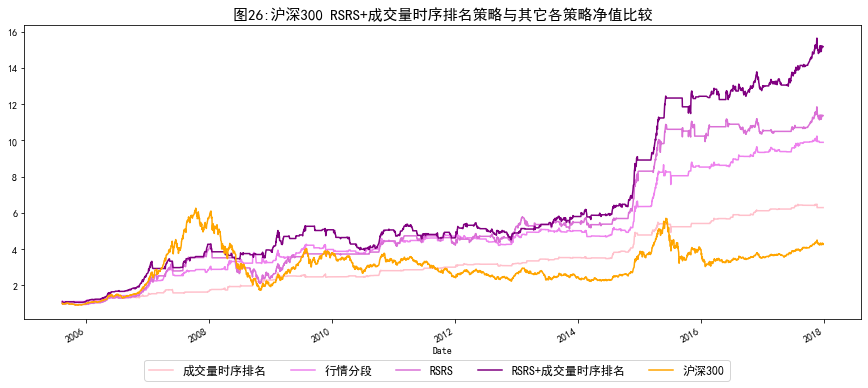

In [69]:
#画图
colors = ['pink', 'violet','orchid',  'purple', 'orange']

axes = figure.plot(figsize=(15, 6))
axes.set_title('图26:沪深300 RSRS+成交量时序排名策略与其它各策略净值比较', fontsize=15)

for j in range(len(figure.columns)): 
        axes.get_lines()[j].set_color(colors[j])
        
axes.legend(bbox_to_anchor=(0.85, -0.12), ncol=len(figure.columns), fontsize=12)
plt.savefig('pics/图26 沪深300 RSRS+成交量时序排名策略与其它各策略净值比较.png')
plt.show()

### 表 10: 上证综指各择时策略统计量(2005.3.14-2017.12.29)

In [70]:
#表10
styler = format_row_wise(pd.DataFrame(stats).style, formatters)
styler.to_excel(writer, '表10 沪深300各择时策略统计量')

In [71]:
styler

,成交量时序排名,行情分段,RSRS,RSRS+成交量时序排名
年化收益,15.5%,19.5%,21.7%,23.5%
夏普比率,1.43,1.35,1.12,1.48
最大回撤,11.7%,17.0%,50.3%,25.6%
交易次数,213,278,48,161
胜率,70.4%,56.1%,70.8%,63.4%
平均盈亏比,1.59,2.12,3.13,1.59


从表10数据来看，13年内，综合策略交易次数161次，

In [72]:
writer.save()